In [51]:
%pip install control

   ---------------------------------------- 0.0/513.9 kB ? eta -:--:--
   ----- ---------------------------------- 71.7/513.9 kB 2.0 MB/s eta 0:00:01
   ----------------------- ---------------- 297.0/513.9 kB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 513.9/513.9 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import control as ctrl

print("Setup Complete")

Setup Complete


In [53]:
ppg_filepath = "../golden_data/ppg_golden_data.csv"

ppg_data = pd.read_csv(ppg_filepath, nrows=1000000)

In [54]:
b_s = [0, 0, 0, 0, 14641] 
a_s = [1, 28.74438523, 413.1198405, 3478.070613, 14641]

system_s = ctrl.TransferFunction(b_s, a_s)
system_z = ctrl.sample_system(system_s, 1/fs, method='tustin')
b_z, a_z = system_z.num[0][0], system_z.den[0][0]

print(a_z)
print(b_z)

[ 1.         -3.71291523  5.17923851 -3.21646505  0.75026859]
[7.92609259e-06 3.17043703e-05 4.75565555e-05 3.17043704e-05
 7.92609258e-06]


In [59]:
# Định nghĩa các tham số
fs = 50.0  # Tần số lấy mẫu, ví dụ 50 Hz
lowcut = 0.5  # Tần số cắt thấp, 0.5 Hz
highcut = 5.0  # Tần số cắt cao, 5 Hz
order = 4  # Bậc của bộ lọc

# Hàm tính toán hệ số bộ lọc Butterworth trong miền tần số liên tục (s-domain)
def butter_bandpass_s(lowcut, highcut, fs, order=4):
    
    b_s = [0, 0, 0, 0, 14641] 
    a_s = [1, 28.74438523, 413.1198405, 3478.070613, 14641]

    #b_s = [0, 0, 0, 0, 410.0625, 0, 0, 0, 0] 
    #a_s = [1, 11.75906669, 79.13782459, 326.3141006, 793.251623, 815.7852513, 494.6114037, 183.735417, 39.0625]

    #b_s = [0, 0, 0, 0, 600.373, 0, 0, 0, 0] 
    #a_s = [1, 12.935, 93.657, 413.951, 1056.156, 1034.879, 585.355, 202.109, 39.063]

    return b_s, a_s

def bilinear_transform(b, a, fs):
    
    #b_z = [0, 5.7580e-06, 5.9773e-05, 5.6433e-05, 4.8459e-06]

    b_z =[7.92609259e-06, 3.17043703e-05, 4.75565555e-05, 3.17043704e-05,
          7.92609258e-06]
    a_z = [1, -3.7128, 5.1789, -3.2162, 0.7502]

    #b_z = [0, 1.668746875510892e-07, 1.125222936892873e-06, -4.418585720620133e-06, 3.240126494715658e-06, 2.880278425193117e-06, -4.278449529637947e-06, 1.129025973719708e-06, 1.555067321856335e-07] 
    #a_z = [1, -7.881440488611725, 27.178018085272930, -53.557535401315930, 65.967830502410950, -52.005912522207050, 25.626087547539484, -7.216107622875697, 0.889059899787052]
    
    #b_z = [0, 2.43745129401545e-07, 1.63736167143364e-06, -6.44126908548316e-06, 4.74210062987023e-06, 4.16597537762391e-06, -6.21691184619847e-06, 1.64345453304748e-06, 2.25543590304835e-07]
    #a_z = [1, -7.86968807723170, 27.0971928994167, -53.3192996705707, 65.5776977093441, -51.6225693182348, 25.4000745355172, -7.14207445672933, 0.878666378488520]
    return b_z, a_z

# Hàm lọc tín hiệu sử dụng các hệ số z-domain
def apply_filter(data, b, a):
    data = np.asarray(data, dtype=np.float64)  # Đảm bảo dữ liệu đầu vào là kiểu float64
    y = np.zeros_like(data, dtype=np.float64)  # Tạo mảng kết quả kiểu float64
    for i in range(len(data)):
        y[i] = b[0] * data[i]
        for j in range(1, len(b)):
            if i-j >= 0:
                y[i] += b[j] * data[i-j]
        for j in range(1, len(a)):
            if i-j >= 0:
                y[i] -= a[j] * y[i-j]
    return y


In [60]:

b_s, a_s = butter_bandpass_s(lowcut, highcut, fs, order)
print(a_s)
print(b_s)

# Chuyển đổi các hệ số từ miền s sang miền z
b_z, a_z = bilinear_transform(b_s, a_s, fs)
print(a_z)
print(b_z)

# Áp dụng bộ lọc
filtered_sig = apply_filter(ppg_data, b_z, a_z)

[1, 28.74438523, 413.1198405, 3478.070613, 14641]
[0, 0, 0, 0, 14641]
[1, -3.7128, 5.1789, -3.2162, 0.7502]
[7.92609259e-06, 3.17043703e-05, 4.75565555e-05, 3.17043704e-05, 7.92609258e-06]


In [61]:
print(filtered_sig)
print(ppg_data)

[[7.77549683e-03]
 [6.77701270e-02]
 [2.97037394e-01]
 ...
 [1.21926621e+03]
 [1.20668341e+03]
 [1.19426193e+03]]
        975
0       981
1       984
2       989
3       992
4       994
...     ...
199729  580
199730  553
199731  544
199732  548
199733  558

[199734 rows x 1 columns]


<Axes: >

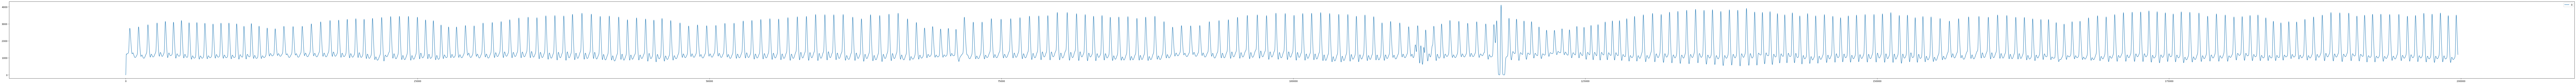

In [62]:
# Hiển thị tín hiệu trước và sau khi lọc
plt.figure(figsize=(200,6))
sns.lineplot(data=filtered_sig)